In [2]:
cd /Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo/

/Users/jz-rolling/Desktop/OMEGA/Notebooks/MSR_manuscript_redo


In [3]:
import numpy as np
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors as cl
from matplotlib.gridspec import GridSpec as gs
import networkx as nx
import seaborn as sns
import miniSAFE as ms
import OMEGA_core as om


In [4]:
# load dataframe
# load dataframe
df = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/rep1_spikein_curated.xls')

# load data
dest_folder = '/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/NMF_output/'
reshaped = np.load(dest_folder+'NMF_regrouped.npy')
h = np.load(dest_folder+'NMF_basis.npy')
w = np.load(dest_folder+'NMF_encoding.npy')
snf_data = pk.load(open('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SNF_output/SNF_output.pk','rb'))
n_components = 20
positions = snf_data['positions']
g = snf_data['network']
pos = snf_data['embedding']
graph = snf_data['composite_graph']
func_tab = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/COG/func_annot.xlsx',index_col='Functional_category')



safe_dict = pk.load(open( "/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/SAFE/SAFE_dict.pk", "rb" ))
gematria_input = np.load('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/packed_rep1_spikein.npy')
gematria_input_filtered = gematria_input[df['Original_index'].values]
graph_data = snf_data['composite_graph']

# map entry ids of the original and selected entries
SAFE_entry_id = df.index[df['SAFE_input']==1].values

In [5]:
def format_names(name_list):
    new_names = []
    for n in name_list:
        if n.startswith('MSMEG'):
            new_names.append(n.split('_')[1])
        elif n in ['mScarlet','mNeonGreen']:
            new_names.append(n)
        else:
            new_names.append(n[0].capitalize()+n[1:])
    return new_names

def min_max_normalization(data, pad=0, sat=1,min_cutoff=0):
    sat_p = np.percentile(data,sat*100)
    min_p = np.percentile(data,min_cutoff*100)
    norm_d = ((data-min_p)/(sat_p-min_p)+pad)/(1+pad)
    norm_d[norm_d>1]=1
    norm_d[norm_d<pad]=pad
    return norm_d


def moving_window_1d(data):
    data1 = np.concatenate([data[:1],data[:-1]])
    data2 = np.concatenate([data[1:],data[-1:]])
    return (data1+data2+data)/3

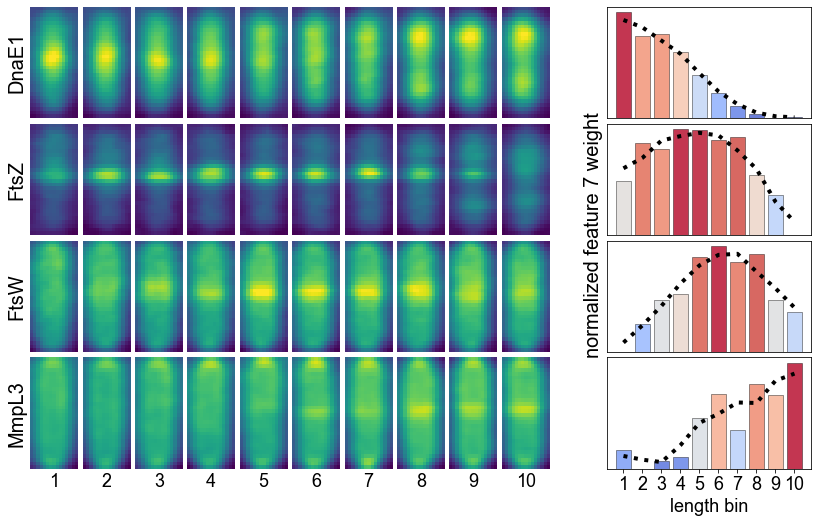

In [12]:
# plot cell cycle ref strains

anchor_entries = {0:[332,'DnaE1'],1:[766,'FtsZ'],2:[426,'FtsW'],3:[45,'MmpL3']}
vmax=[1.8,2.2,1.5,1.5]
fig=plt.figure(figsize=(14,8.5))
grids = gs(4,15,hspace=0.05,wspace=0.1)
for r, v in anchor_entries.items():
    idx, name = v
    axes1 = [fig.add_subplot(grids[r,i]) for i in range(10)]
    axes1[0].set_ylabel(name,fontname='Arial',fontsize=20)
    for l,ax in enumerate(axes1):
        spines = [ax.spines[spine].set_visible(False) for spine in ['top','left','right','bottom']]
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(gematria_input_filtered[idx,l,:].reshape(15,30).T,aspect='auto',vmax=vmax[r])
        if r == 3:
            ax.set_xlabel('{}'.format(l+1),fontname='Arial',fontsize=18)
            
    ax2=fig.add_subplot(grids[r,11:])
    feature7_raw = min_max_normalization(reshaped[idx,:,6],pad=0)
    feature7_smoothed = moving_window_1d(feature7_raw)
    color = cm.get_cmap('coolwarm')([0.2*(r+1)])[0]
    for i,h in enumerate(feature7_raw):
        ax2.bar(x=i+1,height=h,ec='black',lw=0.5,fc=cm.get_cmap('coolwarm')(h),alpha=0.8)
    ax2.plot(np.arange(1,11),feature7_smoothed,lw=4,color='black',ls=':')
    if r == 3:
        ax2.set_xticks(np.arange(1,11))
        ax2.set_xticklabels(np.arange(1,11),fontname='Arial',fontsize=18)
        ax2.set_xlabel('length bin',fontname='Arial',fontsize=18)
    else:
        ax2.set_xticks([])
    ax2.set_yticks([])
    if r == 1:
        ax2.set_ylabel('normalized feature 7 weight',x=0,y=0,fontname='Arial',fontsize=20)
#plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/temporal_samples.png',
#            dpi=100,bbox_inches='tight',transparent=True)

In [10]:
sf = safe_dict['COG'][0.85]
domain_colors = [cm.get_cmap('Set2')(4),
                 cm.get_cmap('Set2')(3),
                 cm.get_cmap('Set2')(2),
                 cm.get_cmap('Set2')(1),
                 cm.get_cmap('Set2')(0),
                 cm.get_cmap('Set2')(5),
                 cm.get_cmap('Set2')(6)]

outlines = []
for i in range(1,len(sf.domains)):
    targets = np.where(sf.node2domain['primary_domain']==i)[0]
    original_idx = SAFE_entry_id[targets]
    x,y = positions[0,original_idx],positions[1,original_idx]
    xy = np.vstack([x, y])
    outlines.append([domain_colors[i],
                     ms.scatter2outline(xy.T,base=20,
                                       ampl_factor=50,
                                       smooth_factor=10,n=100)])

In [17]:
# plot length dependent feature dynamics

from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox

master_norm = np.apply_along_axis(min_max_normalization,1,reshaped)
master_norm = np.apply_along_axis(moving_window_1d,1,master_norm)
master_norm[np.isnan(master_norm)]=0
for i in range(10):
    
    fig = plt.figure(figsize=(15,18.75))
    grids = gs(25,5,hspace=0.05,wspace=0.05)
    ax1 = fig.add_subplot(grids[2:4,0])
    ax2 = fig.add_subplot(grids[4:6,0])
    ax1.set_xlim(-0.1,1.1)
    ax2.set_xlim(-0.1,1.1)
    ax1.set_ylim(0.25,0.75)
    ax2.set_ylim(0.25,0.75)
    ax1.axis('off')
    ax2.axis('off')
    for dx in np.linspace(0,1,6):
        ax1.scatter(dx,0.65,fc='lightgrey',ec='black',s=150*dx+50,alpha=0.6)
        ax2.scatter(dx,0.65,fc=cm.get_cmap('coolwarm')(dx),ec='black',s=150,alpha=0.6)
    ax1.set_title('"Spatial" contribution',fontname='Arial',fontsize=12)
    ax2.set_title('"Temporal" variation',fontname='Arial',fontsize=12)
    ax2.text(0,0.5,'low',fontname='Arial',fontsize=12,va='center',ha='center')
    ax2.text(1,0.5,'high',fontname='Arial',fontsize=12,va='center',ha='center')
    
    for k in range(20):
        
        average_weights = min_max_normalization(np.average(reshaped[:,:,k],axis=1),
                                                pad=0,min_cutoff=0.05)
        norm_d = master_norm[:,:,k]
        r = int(k/5)+1
        c = k%5
        ax= fig.add_subplot(grids[r*5+1:r*5+5,c])
        ax.set_xticks([])
        ax.set_yticks([])
        plt.rcParams["axes.edgecolor"] = "black"
        plt.rcParams["axes.linewidth"]  = 0.5 
        #edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.05, width=0.1,ax=ax1)
        img = OffsetImage(h[k].reshape(15,30),zoom=1.8)
        ab = AnnotationBbox(img, (-0.7, -0.7),bboxprops =dict(edgecolor='black',lw=0.5,boxstyle='Square, pad=0.2'),frameon=True)
        ax.add_artist(ab)
        f7 = norm_d[:,i]
        colors=cm.get_cmap('coolwarm')(f7)
        colors[:,3]=0.6
        ax.scatter(positions[0],positions[1],s=100*average_weights,
                    zorder=2,
                    c=colors, ec=None)
        for c,l in outlines:
            ax.plot(l[:,0],l[:,1],color=c,lw=3,ls='-',zorder=3)
        if k == 0:
            ax.text(0.55,0.8,'core',fontweight='bold',fontname='Arial',fontsize=14,ha='center',va='center')
            ax.text(-0.7,-0.33,'membrane',fontweight='bold',fontname='Arial',fontsize=14,ha='center',va='center')
            ax.text(0.2,-0.78,'cytoplasm',fontweight='bold',fontname='Arial',fontsize=14,ha='center',va='center')
        ax.set_ylim(-0.9,1)
        ax.set_xlim(-1.15,0.85)
        ax.set_title('feature {}'.format(k+1),fontname='Arial',fontsize=16,ha='center',va='center')
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/temporal_fig/feature_maps/feature_map_t{}.png'.format(i),
                dpi=160,bbox_inches='tight',transparent=True)
    plt.close()

/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [18]:
k=6
for i in range(10):
    fig=plt.figure(figsize=(3,3))
    average_weights = min_max_normalization(np.average(reshaped[:,:,k],axis=1),
                                            pad=0,min_cutoff=0.05)
    norm_d = master_norm[:,:,k]
    ax1= plt.subplot(111)
    ax1.axis('off')
    edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.05, width=0.1,ax=ax1)
    f7 = norm_d[:,i]
    colors=cm.get_cmap('coolwarm')(f7)
    colors[:,3]=0.6
    ax1.scatter(positions[0],positions[1],s=100*average_weights,
                    zorder=2,
                    c=colors, ec=None)
    for c,l in outlines:
        ax1.plot(l[:,0],l[:,1],color=c,lw=3,ls='-',zorder=3)
    if i == 1:
        ax1.text(0.55,0.8,'core',fontweight='bold',fontname='Arial',fontsize=16,ha='center',va='center')
        ax1.text(-0.7,-0.33,'membrane',fontweight='bold',fontname='Arial',fontsize=16,ha='center',va='center')
        ax1.text(0.2,-0.78,'cytoplasm',fontweight='bold',fontname='Arial',fontsize=16,ha='center',va='center')
    ax1.text(-0.8,0.8,'L={}'.format(i+1),fontweight='bold',fontname='Arial',fontsize=16,ha='center',va='center')
    ax1.set_ylim(-0.86,0.95)
    #ax1.set_title('feature {}'.format(k+1),fontname='Arial',fontsize=16,ha='center',va='center')
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/temporal_fig/feature7_map_t{}.png'.format(i+1),
            dpi=100,bbox_inches='tight',transparent=True)
    plt.close()

In [111]:
# plot length dependent feature 7 dynamics
k=6
for i in range(10):
    fig=plt.figure(figsize=(3,3))
    average_weights = min_max_normalization(np.average(reshaped[:,:,k],axis=1),
                                            pad=0,min_cutoff=0.05)
    norm_d = master_norm[:,:,k]
    ax1= plt.subplot(111)
    ax1.axis('off')
    edges = nx.draw_networkx_edges(g,pos=pos,edge_color='silver',alpha=0.05, width=0.1,ax=ax1)
    f7 = norm_d[:,i]
    colors=cm.get_cmap('coolwarm')(f7)
    colors[:,3]=0.6
    ax1.scatter(positions[0],positions[1],s=100*average_weights,
                    zorder=2,
                    c=colors, ec=None)
    ax1.text(-0.8,0.8,'L={}'.format(i+1),fontweight='bold',fontname='Arial',fontsize=16,ha='center',va='center')
    ax1.set_ylim(-0.86,0.95)
    #ax1.set_title('feature {}'.format(k+1),fontname='Arial',fontsize=16,ha='center',va='center')
    plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/feature7_map_unlabeled_t{}.png'.format(i+1),
            dpi=100,bbox_inches='tight',transparent=True)
    plt.close()

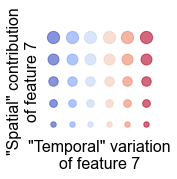

In [19]:
# # plot color code
fig=plt.figure(figsize=(2,2))
ax0 = plt.subplot(111)
for dx in np.linspace(0,1,6):
    for dy in np.linspace(0,1,6):
        ax0.scatter(dx,dy,color=cm.get_cmap('coolwarm')([dx])[0],s=150*dy,alpha=0.6)
ax0.set_ylim(0.1,1.1)
ax0.set_xlim(-0.1,1.1)
spines = [ax0.spines[spine].set_visible(False) for spine in ['top','left','right','bottom']]
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('"Temporal" variation\nof feature 7',fontname='Arial',fontsize=16)
ax0.set_ylabel('"Spatial" contribution\nof feature 7',fontname='Arial',fontsize=16)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/temporal_fig/feature7_annot.png',
            dpi=100,bbox_inches='tight',transparent=True)

In [15]:
from scipy.optimize import curve_fit

def constrained_sinusoidal(x,a,p,c):
    return a*np.sin(2*np.pi*(0.5*x+p))+c

def fit_sinusoidal(xdata,ydata,return_cov = False):
    fitted = curve_fit(constrained_sinusoidal, xdata, ydata,
                       p0=(0.3,0,0),
                       bounds = ([0.01,-4,0],[1,4,1]))
    if return_cov:
        return fitted
    else:
        return fitted[0]
    
def fitMidcell(data):
    fitted_param,cov= fit_sinusoidal(np.linspace(0,1,10),data,return_cov=True)
    fitted=list(constrained_sinusoidal(np.linspace(0,1,10),
                                       fitted_param[0],fitted_param[1],fitted_param[2]))
    perv = list(np.sqrt(np.diag(cov)))
    mse = MSE(data,fitted)
    ks = chi_sq(data,fitted)
    return fitted+perv+list(fitted_param)+[mse] + list(ks)

def MSE(data,fitted):
    return np.mean(np.square(data-fitted))

def NSSE(data,fitted):
    # normalized sum of squared error
    return np.sum(np.sqrt(np.square(data-fitted)))/np.sum(data)

def chi_sq(data,fitted):
    from scipy import stats
    return stats.chisquare(data, f_exp=fitted)

def min_max_norm(data):
    return (data-data.min())/(data.max()-data.min())

In [17]:
# IQR
iqr = np.percentile(reshaped[:,:,6],75,axis=1)-np.percentile(reshaped[:,:,6],25,axis=1)
maxv = np.max(reshaped[:,:,6],axis=1)
# sinusoidal fitting 
fit_stat=[]
cols = ['raw_{}'.format(x+1) for x in range(10)]+\
       ['fitted_{}'.format(x+1) for x in range(10)]+\
       ['perV_A','perV_P','perV_C','A','P','C','MSE','Chi-s','ChiS-pval']
for r in df.iterrows():
    midcell = min_max_norm(reshaped[r[0],:,6])
    fit_stat.append(list(midcell)+fitMidcell(midcell))
    
    
fit_stat_df = pd.DataFrame(np.array(fit_stat),columns=cols)
fit_stat_df['IQR'] = iqr
fit_stat_df[['name','locus']] = df[['name','locus']]
fit_stat_df['Max'] = maxv

/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jz-rolling/Desktop/OMEGA/venv/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator


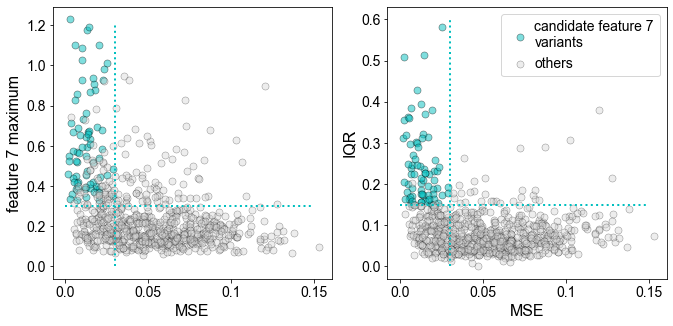

In [19]:
# filter by fit stat
cell_cycle_variants = np.where((fit_stat_df['IQR']>0.15)&(fit_stat_df['MSE']<=0.03)&((fit_stat_df['Max']>=0.3)))[0]
cell_cycle_invariants = np.delete(np.arange(len(df)), cell_cycle_variants)

# plot fit stat

figure,axes = plt.subplots(nrows=1,ncols=2,figsize=(11,5))
ax1,ax2 = axes
iqr_data = fit_stat_df['IQR'].values
mse_data = fit_stat_df['MSE'].values
max_data = fit_stat_df['Max'].values
ax2.scatter(mse_data[cell_cycle_variants],iqr_data[cell_cycle_variants],fc='c',ec='black',alpha=0.5,s=50,lw=0.6,label='candidate feature 7\nvariants')
ax2.scatter(mse_data[cell_cycle_invariants],iqr_data[cell_cycle_invariants],fc='lightgrey',ec='black',alpha=0.4,s=50,lw=0.5,label='others')
ax2.vlines(x=0.03,ymin=0,ymax=0.6,ls=':',lw=2,color='c')
ax2.hlines(y=0.15,xmin=0,xmax=0.15,ls=':',lw=2,color='c')
ax2.set_xticks([0,0.05,0.1,0.15])
ax2.set_xticklabels([str(round(x,2)) for x in ax2.get_xticks()], fontname='Arial',fontsize=14);
ax2.set_yticklabels([str(round(x,2)) for x in ax2.get_yticks()], fontname='Arial',fontsize=14);
ax2.set_xlabel('MSE',fontname='Arial',fontsize=16)
ax2.set_ylabel('IQR',fontname='Arial',fontsize=16)
plt.legend(prop={'family':'Arial','size':14},handletextpad=0)

ax1.scatter(mse_data[cell_cycle_variants],max_data[cell_cycle_variants],fc='c',ec='black',alpha=0.5,s=50,lw=0.6,label='candidate feature 7\nvariants')
ax1.scatter(mse_data[cell_cycle_invariants],max_data[cell_cycle_invariants],fc='lightgrey',ec='black',alpha=0.4,s=50,lw=0.5,label='others')
ax1.vlines(x=0.03,ymin=0,ymax=1.2,ls=':',lw=2,color='c')
ax1.hlines(y=0.3,xmin=0,xmax=0.15,ls=':',lw=2,color='c')
ax1.set_xticks([0,0.05,0.1,0.15])
ax1.set_xticklabels([str(round(x,2)) for x in ax1.get_xticks()], fontname='Arial',fontsize=14);
ax1.set_yticklabels([str(round(x,2)) for x in ax1.get_yticks()], fontname='Arial',fontsize=14);
ax1.set_xlabel('MSE',fontname='Arial',fontsize=16)
ax1.set_ylabel('feature 7 maximum',fontname='Arial',fontsize=16)
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/temporal_fig/cell_cycle_variant_identification.png',dpi=160,bbox_inches='tight')
candidate_feature7_variants = fit_stat_df.iloc[cell_cycle_variants].copy().sort_values(by='P').reset_index(drop=True)
candidate_feature7_variants.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/candidate_feature7_variants.xls')

In [20]:
def format_names(name_list):
    new_names = []
    for n in name_list:
        if n.startswith('MSMEG'):
            new_names.append(n)
        elif n in ['mScarlet','mNeonGreen']:
            new_names.append(n)
        elif n.startswith('ftsZ'):
            new_names.append('FtsZ')
        else:
            new_names.append(n[0].capitalize()+n[1:])
    return new_names

In [22]:
# get GO annotation

go = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/start_over_once_more/references/msm_go.xls')
attributes = pd.unique(go['geneset'])
go_table = np.zeros((len(df),len(attributes)))
go_dict = {}
attributes2idx = {attributes[i]:i for i in np.arange(len(attributes))}

for i in range(len(go)):
    l = go.iloc[i]['locus']
    att = go.iloc[i]['geneset']
    if l not in go_dict:
        go_dict[l] = [attributes2idx[att]]
    else:
        go_dict[l] += [attributes2idx[att]]
        
go_table = np.zeros((len(df),len(attributes)))
for i in range(len(df)):
    l = df.iloc[i]['locus']
    if l in go_dict:
        go_table[i,np.array(go_dict[l])]=1
        
# 
phases = fit_stat_df.iloc[cell_cycle_variants]['P']
phase_sorted_go = go_table[cell_cycle_variants[np.flip(np.argsort(phases))]]
major_attributes_idx = np.where(np.sum(phase_sorted_go,axis=0)>=5)[0]

attributes_selected=[1,15,11,3] # DNA binding, cell cycle, membrane OX-RED
cell_cycle_df = df.iloc[cell_cycle_variants[np.flip(np.argsort(phases))]].copy()

dna_set = ['transcription, DNA-templated','DNA binding','DNA repair', 'DNA replication', 'nucleotide binding','regulation of transcription, DNA-templated']
division_set = ['cell cycle', 'cell division']
membrane = ['integral component of membrane', 'membrane','plasma membrane']
metabolism = ['metabolic process','oxidation-reduction process', 'oxidoreductase activity','transferase activity']

curated_attribute_dict = {'DNA':[attributes2idx[x] for x in dna_set],
                          'cell division':[attributes2idx[x] for x in division_set],
                          'membrane':[attributes2idx[x] for x in membrane],
                          'metabolism':[attributes2idx[x] for x in metabolism]}

curated_attribute2id = {'DNA':0,'cell division':1,'membrane':2,'metabolism':3}

annotations = []
curated_table = np.zeros((len(cell_cycle_df),4))

for i, locus in enumerate(cell_cycle_df['locus'].values):
    annotation = '-'
    if locus in go_dict:
        goid = go_dict[locus]  
        for k,v in curated_attribute_dict.items():
            if len(list(set(v)&set(goid))) > 0:
                curated_table[i,curated_attribute2id[k]] = 1
                if annotation == '-':
                    annotation = k
                else:
                    annotation += '; {}'.format(k)
    annotations.append(annotation)
cell_cycle_df['Curated GO annotation(s)'] = annotations
cell_cycle_df.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/cell_cycle.xlsx')

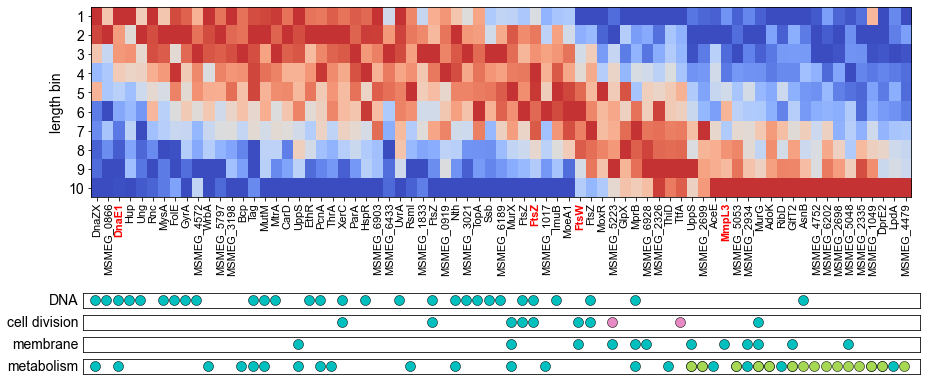

In [24]:
# plot phase-sorted feature 7 heatmap
anchor_entries = [332,766,426,45]
fit_stat_df['index'] = fit_stat_df.index
candidate_feature7_variants = fit_stat_df.iloc[cell_cycle_variants].copy().sort_values(by='P').reset_index(drop=True)
candidate_feature7_variants.to_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/candidate_feature7_variants.xls')
fig=plt.figure(figsize=(15,10))
grid=gs(50,100,hspace=2)
ax=fig.add_subplot(grid[:18,1:-1])
ax.imshow(np.flip(candidate_feature7_variants[cols[:10]].values.T,axis=1),cmap='coolwarm',aspect='auto',vmax=1.05)
plt.tick_params(axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=True,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                left=False,
                right=False,
                labelbottom=True,
                labelleft=True) # labels along the bottom edge are off
ax.set_xticks(np.arange(len(candidate_feature7_variants)))
#ax.set_xticklabels(format_names(np.flip(candidate_feature7_variants['name'].values)),
#                   rotation=90,fontname='Arial',fontsize=11,ha='center',va='top');
ax.set_xticklabels(['']*len(candidate_feature7_variants))
names = format_names(np.flip(candidate_feature7_variants['name'].values))
indices = np.flip(candidate_feature7_variants['index'].values)
for i,name in enumerate(names):
    x=i
    y=9.75
    if indices[i] in anchor_entries:
        c='red'
        w='bold'
    else:
        c='black'
        w='normal'
    ax.text(x,y,name,color=c,weight=w,rotation=90,va='top',ha='center',fontname='Arial',fontsize=11)
ax.set_yticks(np.arange(10))
ax.set_yticklabels([1,2,3,4,5,6,7,8,9,10],fontname='Arial',fontsize=14);
ax.set_ylabel('length bin',fontname='Arial',fontsize=14)

rows=[fig.add_subplot(grid[i:i+2,:]) for i in [26,28,30,32]]
for ax in rows:
    ax.set_yticks([])
    ax.set_xticks([])
    

pad = 98/len(cell_cycle_variants)
for i, (k,v) in enumerate(curated_attribute2id.items()):    
    ax = rows[i]
    hits = np.where(curated_table[:,i]>0)[0]
    ax.scatter(x=1.5+hits*pad,y=np.ones(len(hits))*0.5,s=100,fc='c',ec='black',lw=0.5)
    ax.set_ylim(0.45,0.55)
    ax.set_xlim(0,100)
    plt.tick_params(axis='both',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    left=False,
                    right=False,
                    labelbottom=False,
                    labelleft=False) # labels along the bottom edge are off
    size=14
    ax.set_ylabel(k,rotation=0,fontname='Arial',
                  fontsize=size,va='center',ha='right')

divi = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/references/divi.xlsx')['locus'].values
for j,l in enumerate(np.flip(candidate_feature7_variants['locus'].values)):
    ax = rows[1]
    if l in divi:
        ax.scatter(x=1.5+j*pad,y=0.5,s=100,fc=cm.get_cmap('Set2')(3),ec='black',lw=0.5)

imd = pd.read_excel('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/imd_plots/imd_list.xlsx')['locus'].values
for j,l in enumerate(np.flip(candidate_feature7_variants['locus'].values)):
    ax = rows[3]
    if l in imd:
        ax.scatter(x=1.5+j*pad,y=0.5,s=100,fc=cm.get_cmap('Set2')(4),ec='black',lw=0.5)

plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/temporal_final.png',
            dpi=160,bbox_inches='tight',transparent=True)

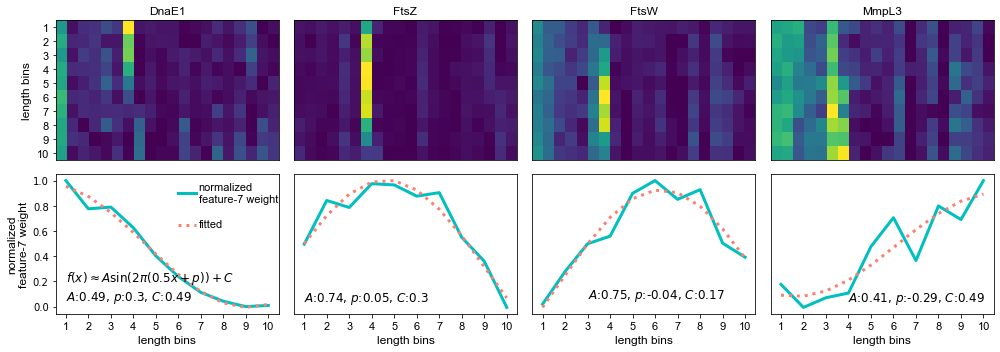

In [18]:
anchor_entries = {0:[332,'DnaE1'],1:[766,'FtsZ'],2:[426,'FtsW'],3:[45,'MmpL3']}
xoffset=[0,0,2,3]
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(14,5),tight_layout=True)
for c in range(4):
    entry =anchor_entries[c]
    ax1 = axes[0,c]
    ax1.set_xticks([])
    ax1.set_title(entry[1],fontname='Arial',fontsize=12)
    
    ax2 = axes[1,c]
    if c !=0:
        ax1.set_yticks([])
        ax2.set_yticks([])
    else:
        ax1.set_yticks([])
        ax1.set_yticks(np.arange(10))
        ax1.set_yticklabels([1,2,3,4,5,6,7,8,9,10],fontname='Arial',fontsize=11);
        ax1.set_ylabel('length bins',fontname='Arial',fontsize=12)
        ax2.plot([6,6.8],[0.9,0.9],color='c',lw=3)    
        ax2.text(6.9,0.9,'normalized\nfeature-7 weight',ha='left',va='center',fontname='Arial',fontsize=11)
        ax2.plot([6,6.8],[0.65,0.65],color='salmon',lw=3,ls=':')    
        ax2.text(6.9,0.65,'fitted',ha='left',va='center',fontname='Arial',fontsize=11)
        ax2.set_ylabel('normalized\nfeature-7 weight',fontname='Arial',fontsize=12)
        ax2.annotate(r"$f(x) \approx A{\rm sin}(2\pi (0.5x + p)) +C$",xy=(1,0.2),fontname='Arial',fontsize=12)
    A,P,C = fit_stat_df.iloc[entry[0]][['A','P','C']].values
    ax2.annotate(r"$A$:{}, $p$:{}, $C$:{}".format(round(A,2),round(P,2),round(C,2)),xy=(1+xoffset[c],0.05),fontsize=12)
    ax1.imshow(reshaped[entry[0]],aspect='auto')
    feature7_raw = min_max_normalization(reshaped[entry[0],:,6],pad=0)
    ax2.plot(np.arange(1,11),feature7_raw,color='c',lw=3)
    fitted = fit_stat_df.iloc[entry[0]][['fitted_{}'.format(i) for i in range(1,11)]].values
    ax2.plot(np.arange(1,11),fitted,color='salmon',lw=3,ls=':')
    ax2.set_xticks(np.arange(1,11))
    ax2.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontname='Arial',fontsize=11);
    ax2.set_xlabel('length bins',fontname='Arial',fontsize=12)
    
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/revision_1/figures/example_temporal.png',
            dpi=160,bbox_inches='tight',transparent=True)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from datetime import datetime

fun_dict = {}

#three example functions
def f(x, p0, p1):
    return p0 * x + p1

def g(x, p0, p1):
    return p0 * np.exp(x * p1)

def h(x, p0, p1, p2):
    return p0 * x ** 2 + p1 * x + p2

f_string = '$y = p0 \cdot x + p1 $'
fun_dict['f'] = f_string
g_string = '$y = p0 \cdot e^{p1 \cdot x} $'
fun_dict['g'] = g_string
h_string = '$y = p0 \cdot x^2 + p1 \cdot x + p2$'
fun_dict['h'] = h_string
#example data
xval = np.array([0,1,2,3,4,5,6])
yval = np.array([0, 2,3.95,5.8,8.1, 10.2, 12.4])


def get_fun(func):
    popt, _ = curve_fit(func, xval, yval)
    return popt, fun_dict[str(func.__name__)], func

popt, str_name, func = get_fun(h)

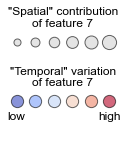

In [187]:
# # plot color code
fig,axes=plt.subplots(nrows=2,figsize=(2,2))
ax1,ax2 = axes
ax1.set_xlim(-0.1,1.1)
ax2.set_xlim(-0.1,1.1)
ax1.set_ylim(0.25,0.75)
ax2.set_ylim(0.25,0.75)
ax1.axis('off')
ax2.axis('off')
for dx in np.linspace(0,1,6):
    ax1.scatter(dx,0.65,fc='lightgrey',ec='black',s=150*dx+50,alpha=0.6)
    ax2.scatter(dx,0.65,fc=cm.get_cmap('coolwarm')(dx),ec='black',s=150,alpha=0.6)
ax1.set_title('"Spatial" contribution\nof feature 7',fontname='Arial',fontsize=12)
ax2.set_title('"Temporal" variation\nof feature 7',fontname='Arial',fontsize=12)
ax2.text(0,0.5,'low',fontname='Arial',fontsize=12,va='center',ha='center')
ax2.text(1,0.5,'high',fontname='Arial',fontsize=12,va='center',ha='center')
"""
ax0.set_ylim(0.1,1.1)
spines = [ax0.spines[spine].set_visible(False) for spine in ['top','left','right','bottom']]
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('"Temporal" variation\nof feature 7',fontname='Arial',fontsize=16)
ax0.set_ylabel('"Spatial" contribution\nof feature 7',fontname='Arial',fontsize=16)
"""
plt.savefig('/Users/jz-rolling/Desktop/MSR_OMEGA_manuscript/Another_try/figures/feature7_annot.png',
            dpi=100,bbox_inches='tight',transparent=True)

In [5]:
gematria_input_filtered.shape

(777, 10, 450)

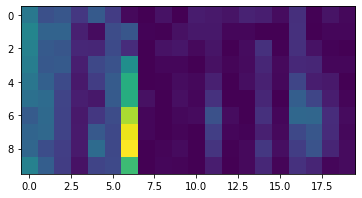

In [10]:
plt.imshow(reshaped[722])

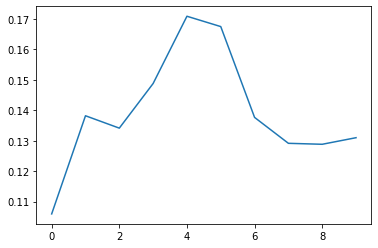

In [14]:
plt.plot(reshaped[722][:,5])